In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('../../data/census_bureau_acs.csv')

## Mean income in the US:

In [3]:
# calculating mean income in the US
mean_income_us = sum(df['total_pop']*df['income_per_capita'])/df['total_pop'].sum()
print(f'Mean income in the US >> ${round(mean_income_us, 2)}')

Mean income in the US >> $32411.26


In [4]:
# transforming table for Mean and Median estimation
state_name_map = {48: 'TX', 12: 'FL', 36: 'NY', 6: 'CA'}

# getting mean income data across the country
df1 = df.T.drop(['total_pop', 'income_per_capita', 'geo_id'], axis=0)
df1['US'] = round(df1.sum(axis=1)/df1.count(axis=1), 2)

geoid = ['06', '36', '48', '12']
df = df[df['geo_id'].isin(geoid)].drop(['total_pop', 'income_per_capita'], axis=1).set_index('geo_id')
df = df.T.rename(columns=state_name_map)
df = pd.concat([df, df1['US']], axis=1)

## Mathematical derivation of Median and Mean income by state from income bins

In [5]:
# helper function that creates all necessary transformations for Mean, Median and Skew estimation
def df_estimate_transform(dataframe, state_list):
    dataframe = dataframe.reset_index()
    dataframe['index'] = dataframe['index'].str.replace('income_', '').str.replace('less', '0').str.replace('or_more', '250000').str.replace('_', '-')
    dataframe['bin_lower'] = dataframe['index'].apply(lambda x: x.split('-')[0]).astype(int)
    dataframe['bin_upper'] = dataframe['index'].apply(lambda x: x.split('-')[1]).astype(int)
    dataframe['bin_mean'] = (dataframe['bin_upper'] + dataframe['bin_lower'])/2
    dataframe['bin_width'] = dataframe['bin_upper'] - dataframe['bin_lower']
    dataframe['bin_width_norm'] = round(dataframe['bin_width']/min(dataframe['bin_width']))
    dataframe['bin_width_norm'] = round(dataframe['bin_width']/min(dataframe['bin_width']))

    # adding new calculated columns
    for state in state_list:
        # calculating histogram height for each state and bin
        dataframe[f'{state}_hist'] = round(dataframe[f'{state}']/dataframe['bin_width_norm'], 2)
        # calculating cumulative areas under the histogram
        dataframe[f'{state}_cumul_area'] = dataframe[f'{state}'].cumsum().tolist()
        # calculating cumulative percentage
        dataframe[f'{state}_percentile'] = round(dataframe[f'{state}'].cumsum()*100/dataframe[f'{state}'].sum(), 2)
        
    return dataframe

In [6]:
state_list = ['TX', 'CA', 'NY', 'FL', 'US']
df = df_estimate_transform(df, state_list)

In [7]:
# function for estimating Mean, Median and Skew by state
def mean_med_skew(dataframe, state_abbrev):
#     calculating the range that the median falls in
#     current_bin - index of lower limit of the bin where the median falls
    current_bin = 0
    cumul_areas = dataframe[f'{state_abbrev}_cumul_area'].tolist()
    for ind, num in enumerate(cumul_areas):
#         area under histogram on both sides of the median
        median_area = dataframe[f'{state_abbrev}'].sum()/2 
        if median_area >= num:
            current_bin = ind+1
            cumul_area = num
    bin_bottom_income = dataframe['bin_lower'].tolist()[current_bin]
#     remaining area 
    residual_area = median_area - cumul_area

    current_bin_width = dataframe['bin_width'].tolist()[current_bin]
    current_bin_freq = dataframe[f'{state_abbrev}'].tolist()[current_bin]
    residual_len = (current_bin_width * residual_area)/current_bin_freq

#     HELPER PLOTS FOR DEBUGGING
#     print(f'Area under histogram on the sides of the median is {median_area}')
#     print(f'Median falls into bin #{current_bin}')
#     print(f'Bottom income for the bin is {bin_bottom_income}')
#     print(f'Cumulative area on the left the bin lower limit is {cumul_area}')
#     print(f'The residual area under the histogram is {residual_area}')
#     print(f'The residual length from bottom range of the bin is {round(residual_len, 2)}')

    incomes = dataframe['bin_mean']
    freq = dataframe[f'{state_abbrev}'].astype(int).tolist()
    all_incomes = [[inc]*fr for inc, fr in zip(incomes, freq)] # clone mean incomes by frequencies
    all_incomes = [j for i in all_incomes for j in i] # flatten list of lists

    median_income = round(bin_bottom_income + residual_len)
    mean_income = round((dataframe['bin_mean']*dataframe[f'{state_abbrev}_hist']).sum()/dataframe[f'{state_abbrev}'].sum(), 2) 
    skew = round(pd.Series(all_incomes).skew(), 2)
    
#     print(f'Mean income per household in {state_abbrev} >> ${round(mean_income, 2)}') 
#     print(f'Median income per household in {state_abbrev} >> ${round(median_income, 2)}')
#     print(f'Skew for {state_abbrev} >> {round(skew, 2)}')
    
    return({'mean': mean_income,
            'median': median_income,
            'skew': skew        
    })

## Mean and Median annual household income in Texas, California, New York and Florida

In [30]:
results_2018 = []
for state in state_list:
    result = mean_med_skew(df, state)
    result['state'] = state
    res_mean = result['mean']
    res_median = result['median']
    res_skew = result['skew']
    print(f'Mean income per household in {state} >> ${res_mean}') 
    print(f'Median income per household in {state} >> ${res_median}')
    print(f'Skew for {state} >> {res_skew}')

Mean income per household in TX >> $23525.69
Median income per household in TX >> $60922.0
Skew for TX >> 1.01
Mean income per household in CA >> $23122.04
Median income per household in CA >> $75351.0
Skew for CA >> 0.68
Mean income per household in NY >> $22768.45
Median income per household in NY >> $68363.0
Skew for NY >> 0.78
Mean income per household in FL >> $23800.69
Median income per household in FL >> $55983.0
Skew for FL >> 1.18
Mean income per household in US >> $23389.37
Median income per household in US >> $62037.0
Skew for US >> 0.98


In [138]:
mean_med_skew(df, 'TX')

{'mean': 23525.69, 'median': 60922.0, 'skew': 1.01}

## Rough resemblance of a histogram for incomes

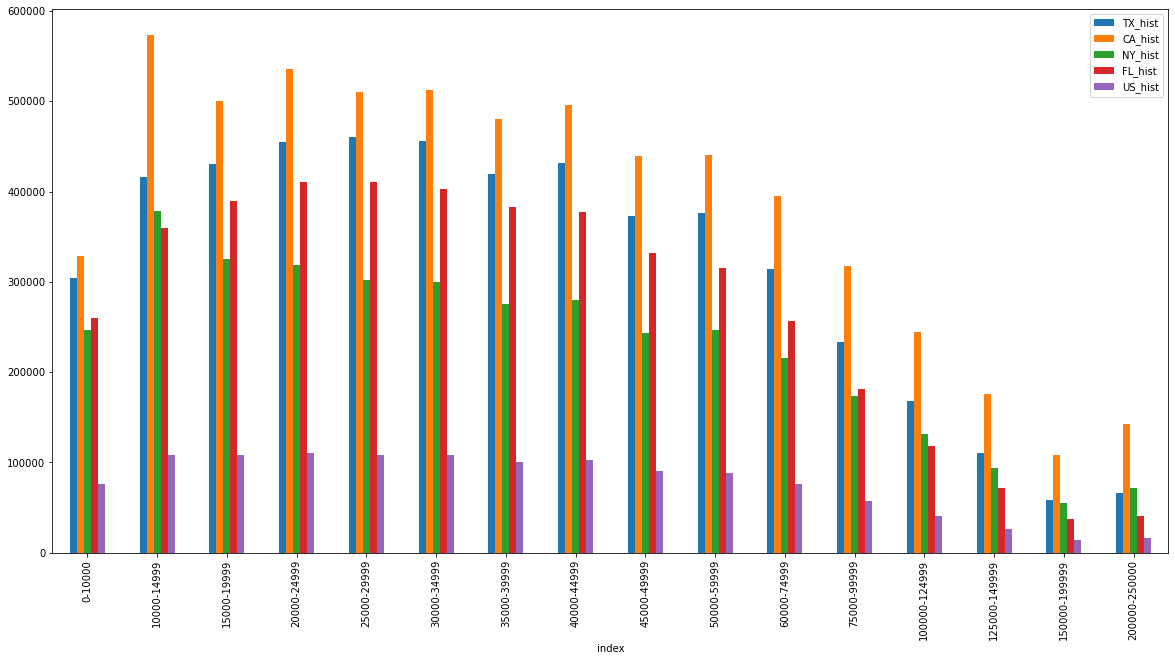

In [9]:
hist_cols = [col for col in df.columns if 'hist' in col]
df[hist_cols+['index']].set_index('index').plot.bar(figsize=(20,10))

In [10]:
def get_percentile_10(dataframe, state):
    cumul_percent = dataframe[f'{state}_percentile']
    bin_mean = dataframe['bin_mean'].tolist()

    perc_income = []
    perc_list = list(range(10, 101, 10))

    for pt in perc_list:
        for idx, cp in enumerate(cumul_percent):
                if pt <= cp:
                    perc_income.append(bin_mean[idx])
                    break

    percentile = pd.DataFrame({'percentile': perc_list, f'{state}_mean_income': perc_income}).set_index('percentile')
    return percentile

In [27]:
percentile = pd.concat([
    get_percentile_10(df, 'CA'),
    get_percentile_10(df, 'NY'),
    get_percentile_10(df, 'FL'),
    get_percentile_10(df, 'TX'), 
    get_percentile_10(df, 'US')],
    axis=1)

## Percentile graph

In [34]:
percentile

,CA_mean_income,NY_mean_income,FL_mean_income,TX_mean_income,US_mean_income
percentile,,,,,
10,17499.5,12499.5,12499.5,12499.5,12499.5
20,27499.5,22499.5,22499.5,27499.5,27499.5
30,42499.5,37499.5,32499.5,37499.5,37499.5
40,54999.5,54999.5,42499.5,47499.5,47499.5
50,87499.5,67499.5,54999.5,67499.5,67499.5
60,87499.5,87499.5,67499.5,87499.5,87499.5
70,112499.5,112499.5,87499.5,87499.5,87499.5
80,174999.5,137499.5,112499.5,112499.5,112499.5
90,225000.0,225000.0,174999.5,174999.5,174999.5


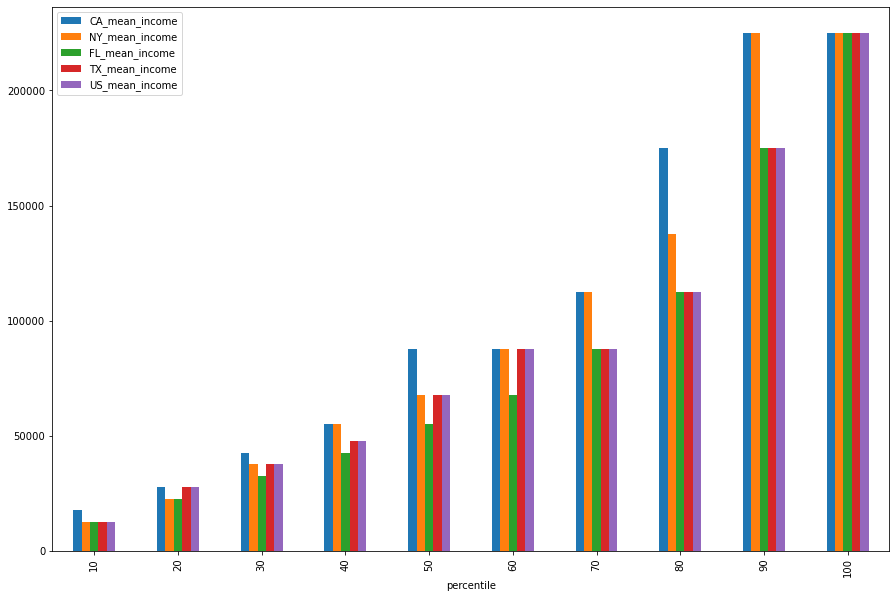

In [28]:
percentile.plot.bar(figsize=(15,10))

In [119]:
df1 = pd.read_csv('../../data/census_bureau_acs_2013-2018.csv')

In [120]:
# getting income data across the country
income_us = df1.drop(['total_pop', 'income_per_capita', 'geo_id'], axis=1).groupby('do_date').sum().T/52

In [121]:
# helper function for transforming initial table for Mean, Median and Skew estimation
def df_transform(dataframe, year):  
    dataframe = dataframe[dataframe['do_date'] == year]
    dataframe = dataframe[dataframe['geo_id'].isin(geoid)]
    dataframe = dataframe.set_index('geo_id').T.drop(['total_pop', 'income_per_capita', 'do_date'], axis=0).rename(columns=state_name_map)
    dataframe['year'] = year
    return dataframe

In [122]:
df_2013 = pd.concat([df_transform(df1, 2013), pd.DataFrame({'US': income_us[2013]})], axis=1)
df_2014 = pd.concat([df_transform(df1, 2014), pd.DataFrame({'US': income_us[2014]})], axis=1)
df_2015 = pd.concat([df_transform(df1, 2015), pd.DataFrame({'US': income_us[2015]})], axis=1)
df_2016 = pd.concat([df_transform(df1, 2016), pd.DataFrame({'US': income_us[2016]})], axis=1)
df_2017 = pd.concat([df_transform(df1, 2017), pd.DataFrame({'US': income_us[2017]})], axis=1)
df_2018 = pd.concat([df_transform(df1, 2018), pd.DataFrame({'US': income_us[2018]})], axis=1)

In [123]:
df_2013 = df_estimate_transform(df_2013, state_list)
df_2014 = df_estimate_transform(df_2014, state_list)
df_2015 = df_estimate_transform(df_2015, state_list)
df_2016 = df_estimate_transform(df_2016, state_list)
df_2017 = df_estimate_transform(df_2017, state_list)
df_2018 = df_estimate_transform(df_2018, state_list)

In [124]:
df_list = [df_2013, df_2014, df_2015, df_2016, df_2017, df_2018]
year_list = [2013, 2014, 2015, 2016, 2017, 2018]

result_2013_2018 = []
for df, yr in zip(df_list, year_list):
    for state in state_list:
        res = mean_med_skew(df, state)
        res['year'] = yr
        res['state'] = state
        result_2013_2018.append(res)

In [125]:
result_2013_2018 = pd.DataFrame(result_2013_2018).sort_values(['state', 'year']).reset_index().drop('index', axis=1)

In [126]:
# calculating growth rates for Mean, Median and Skew

mean_growth_rate = []
median_growth_rate = []
skew_growth_rate = [] 

metrics = ['mean', 'median', 'skew']
metrics_res = [mean_growth_rate,
           median_growth_rate,
           skew_growth_rate]

for state in sorted(state_list):
    for metric, metric_r in zip(metrics, metrics_res):
#         metric_r.append(0) #we don't know previous year rate so the growth rate start point would be 0
        lst = result_2013_2018[result_2013_2018['state']==f'{state}'][f'{metric}'].tolist()
        for idx in range(1,len(lst)):
            metric_r.append(round(100*(lst[idx]-lst[idx-1])/lst[idx-1], 2))

In [127]:
temp = pd.DataFrame({'mean_gr': mean_growth_rate, 
                  'median_gr': median_growth_rate, 
                  'skew_gr': skew_growth_rate})

In [128]:
result_2013_2018 = pd.concat([result_2013_2018[result_2013_2018['year'] != 2013].reset_index().drop('index', axis=1), temp], 
                             axis=1)

In [135]:
result_2013_2018['year'] = result_2013_2018['year'].astype(str)

In [132]:
def plot_growth_rate(dataframe, state):
    plt.plot( 'year', 'mean_gr', data=dataframe[dataframe['state']==state], markersize=12, color='skyblue', label="mean", linewidth=1)
    plt.plot( 'year', 'median_gr', data=dataframe[dataframe['state']==state], markersize=12, color='red', label="median", linewidth=1)
    plt.plot( 'year', 'skew_gr', data=dataframe[dataframe['state']==state], markersize=12, color='green', label="skew", linewidth=1)

    plt.xlabel("Year")
    plt.ylabel("YoY % Change")
    plt.title(state)

    plt.legend(loc='upper left',
               ncol=1, borderaxespad=0.)

## Mean, Median and Skew growth rate 2013-2018

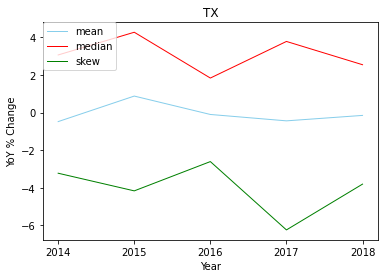

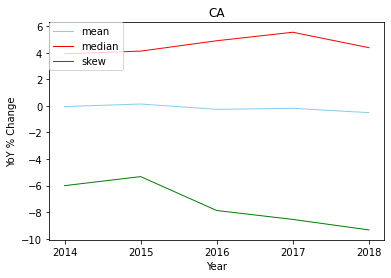

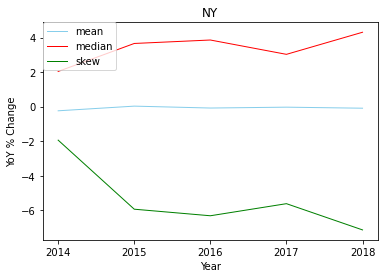

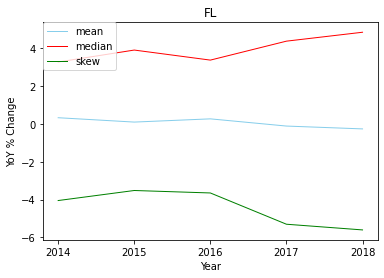

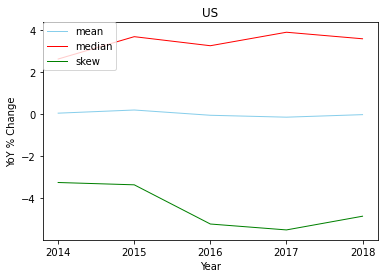

In [137]:
for state in state_list:
    fig, axs = plt.subplots(1)
    plot_growth_rate(result_2013_2018, state)